In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import numpy as np
from pathlib import Path
import os
import pandas as pd
from captum.attr import IntegratedGradients
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import json
from scipy.signal import find_peaks


from src.utils import create_uniform_energy_grid, apply_horizontal_shift, correct_spectrum, shift_test_batch, normalize_spectra_by_area
from src.peak_annotator import get_model_predictions, generate_counterfactual_spectra, assign_peaks_from_counterfactuals, plot_annotated_regions
from src.models import MultiClassifierV2_STN, CVAE


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Optionally, you can print more details about the GPU if available
if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"Number of GPUs available: {torch.cuda.device_count()}")


Using device: cuda
GPU Name: Tesla T4
Number of GPUs available: 1


In [2]:

start_energy = 40
end_energy = 700
BE_values = create_uniform_energy_grid(start_energy, end_energy)

In [3]:
import torch

# Load the entire dictionary object
test_data = torch.load('../data/synthetic_data_hard_final/test_data.pt')

# Access each item by its key
X_test = test_data['features']
y_test = test_data['labels']


# Now you can use these tensors for evaluation
print(f"Loaded features shape: {X_test.shape}")
print(f"Loaded labels shape: {y_test.shape}")


Loaded features shape: torch.Size([20000, 6601])
Loaded labels shape: torch.Size([20000, 40])


In [4]:

# 4. Create an instance of the model and send it to target device
classifier = MultiClassifierV2_STN().to(device)

# Load the saved model
model_path = Path("../../../local_models/STN_3_shift.pth")


classifier.load_state_dict(torch.load(model_path))
classifier.eval()

cvae_path = Path("/home/issa/new_project_clone/local_models/CVAE1d(alkane).pth")
latent_dim = 1
input_dim = 6601
cond_dim = 40

# Initialize model
CVAE = CVAE(input_dim, latent_dim, cond_dim).to(device)
# Load the trained model
CVAE.load_state_dict(torch.load(cvae_path))
CVAE.eval()  # Set the model to evaluation mode

CVAE(
  (encoder_layers): Sequential(
    (0): Linear(in_features=6641, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): Dropout(p=0.3, inplace=False)
    (5): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (6): LeakyReLU(negative_slope=0.2)
  )
  (fc_mu_logvar): Linear(in_features=256, out_features=2, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=41, out_features=512, bias=True)
    (1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (6): LeakyReLU(negative_slope=0.2)
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=1024, out_features=512, bias=True)

In [5]:
def assign_peaks_by_area_overlap(aligned_spectrum_np, generated_spectra_dict):
    """
    Finds peaks and assigns them by finding the counterfactual spectrum
    with the minimum area under each peak's width.
    """
    # Request width properties from find_peaks
    peaks, properties = find_peaks(aligned_spectrum_np, height=0.001, width=1)
    
    # Get the interpolated start and end points of the width
    left_ips = properties["left_ips"]
    right_ips = properties["right_ips"]
    
    peak_assignments = {}
    
    # Enumerate over peaks to access corresponding width data
    for i, peak_idx in enumerate(peaks):
        min_area = np.inf
        assigned_fg = None
        
        # Define the start and end indices for the area calculation
        start_idx = int(np.floor(left_ips[i]))
        end_idx = int(np.ceil(right_ips[i]))

        for fg_idx, spectrum in generated_spectra_dict.items():
            # Sum the intensities in the generated spectrum over the peak's width
            area = np.sum(spectrum[start_idx:end_idx])
            
            if area < min_area:
                min_area = area
                assigned_fg = fg_idx
                
        peak_assignments[peak_idx] = assigned_fg
        
    return peaks, peak_assignments

In [22]:

# =============================================================================
# --- Main Execution Workflow ---
# =============================================================================

# --- 1. Setup & Data Preparation ---
# Assume FG_list, model_0, X_test, y_test, BE_values, and device are defined
# Assume apply_horizontal_shift, correct_spectrum, classifier, CVAE are defined
SAMPLE_INDEX =21
MAX_SHIFT_IN_INDICES = 30
latent_dim = 1 # Example value, ensure this is defined

--- Prediction Summary for Sample ---
 Functional Group  Actual  Predicted
ether (aliphatic)     1.0        0.0
  carboxylic acid     1.0        0.0
        anhydride     1.0        1.0
           alkane     1.0        1.0
---------------------------------------------

Found 2 positive predictions. Generating explanations.
Identified 2 active regions for plotting.
Lowest energy peak in alkane region identified at index: 2455


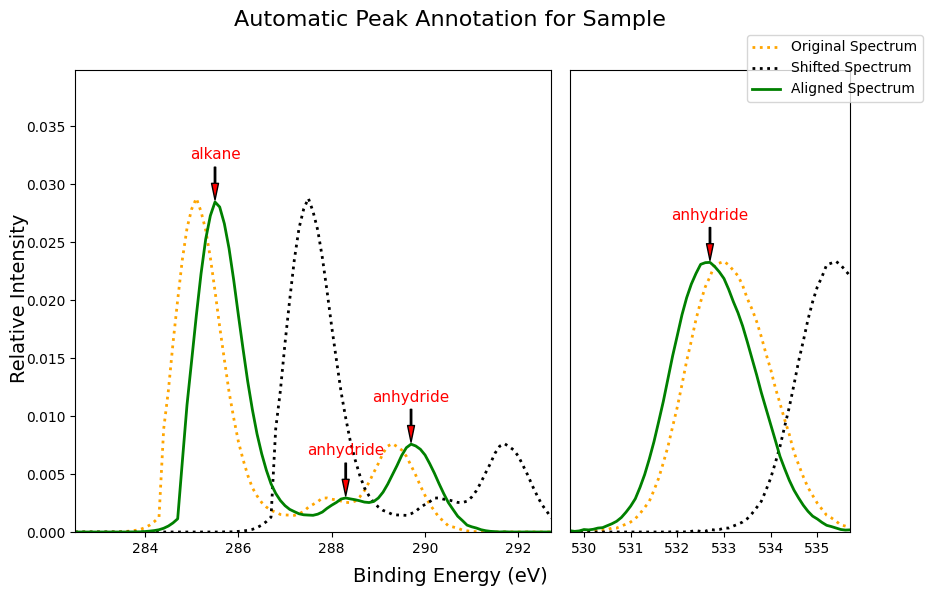

In [ ]:

# Load data
original_spectrum_np = X_test[SAMPLE_INDEX]
true_labels = y_test[SAMPLE_INDEX].to(device)
with open("../data/FG_list.json", "r") as f:
    FG_list = json.load(f)
BE_values_np = np.array(BE_values)

# Apply random shift and convert to tensor
shifted_spectrum_np = apply_horizontal_shift(original_spectrum_np, MAX_SHIFT_IN_INDICES)
shifted_spectrum_tensor = torch.from_numpy(shifted_spectrum_np).unsqueeze(0).to(device)

# --- 2. Get Model Predictions ---
predictions_np, positive_class_indices, aligned_spectrum_np_raw = get_model_predictions(
    shifted_spectrum_tensor, true_labels, FG_list, classifier
)
# Apply post-processing correction
aligned_spectrum_np = correct_spectrum(aligned_spectrum_np_raw, 0)

# --- 3. Generate Explanations ---
generated_spectra_dict = generate_counterfactual_spectra(
    predictions_np, positive_class_indices, CVAE, latent_dim, device
)

# --- 4. Assign Peaks ---
if generated_spectra_dict:

    '''
    peaks, peak_assignments = assign_peaks_from_counterfactuals(
        aligned_spectrum_np, generated_spectra_dict
    )
    '''

    peaks, peak_assignments = assign_peaks_by_area_overlap(
        aligned_spectrum_np, generated_spectra_dict
    )
    
    # --- 5. Plot Results ---
    plot_annotated_regions(
        original_spectrum=original_spectrum_np,
        shifted_spectrum=shifted_spectrum_np,
        aligned_spectrum=aligned_spectrum_np,
        peaks=peaks,
        peak_assignments=peak_assignments,
        be_values=BE_values_np,
        fg_list=FG_list,
        predictions=predictions_np,
        sample_index=SAMPLE_INDEX
    )


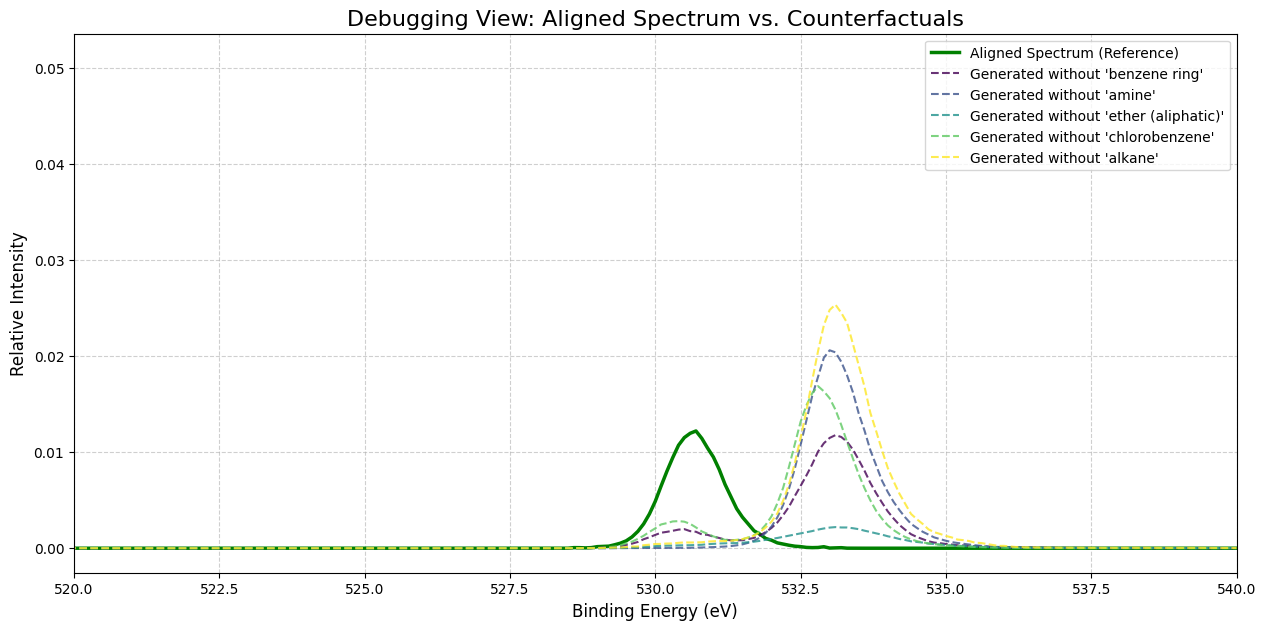

In [15]:
from peak_annotator import plot_counterfactuals_for_debugging


plot_counterfactuals_for_debugging(aligned_spectrum_np
                                   , generated_spectra_dict,
                                     BE_values_np, 
                                     FG_list)


plt.xlim(520,540)
plt.show()